Data on confirmed COVID-19 cases in Scotland by Health board taken from the Web Archive [WayBackMachine](https://web.archive.org/web/*/https://www. gov.scot/coronavirus-covid-19/) capture of the Scottish Government published health board data published since 2020-03-05 ( broken down by specific health boards ).

In [1]:
pip install descartes html2text geopandas lxml matplotlib pandas tabulate word2number xarray 

Note: you may need to restart the kernel to use updated packages.


In [2]:
from datetime import datetime
import os

from tabulate import tabulate
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib
import matplotlib.pyplot as plt

In [1]:
import ScotlandCOVID19

In [99]:
reload(ScotlandCOVID19)

<module 'ScotlandCOVID19' from '/home/jamesmorrison/Scotland_COVID-19/ScotlandCOVID19.py'>

In [100]:
results = []
for date in range(20200306, yesterday+2):
    results.append(ScotlandCOVID19.ScotlandCOVID19.from_date(str(date)))

20200306
 6 March 2020
1525
20200307
 7 March 2020
1680
20200308
 8 March 2020
1957
20200309
 9 March 2020
&nbsp;2,101
20200310
10 March 2020
&nbsp;2,234
20200311
11 March 2020
&nbsp;2,316
20200312
12 March 2020
&nbsp;2,892
20200313
13 March 2020
3,314
20200314
14 March 2020
3,715
20200315
15 March 2020
4,240
20200316
16 March 2020
4,895
20200317
17 March 2020
5,246
20200318
18 March 2020
6,091
20200319
19 March 2020
<span>6772</
20200320
20 March 2020
7550
20200321
21 March 2020
8259
20200322
22 March 2020
8679
20200323
23 March 2020
9364
20200324
5183
9,968
20200325
5183
9,968


In [25]:
yesterday = int(str(datetime.now())[:10].replace('-',''))-1

In [11]:
results = []

In [348]:
results.append(ScotlandCOVID19.ScotlandCOVID19.from_latest_government())

Latest
2269
11,487


In [349]:
all_results = ScotlandCOVID19.ScotlandCOVID19Results(results)

In [350]:
all_results.to_netcdf()

In [351]:
all_results.counts

Health board,Ayrshire and Arran,Borders,Dumfries and Galloway,Fife,Forth Valley,Grampian,Greater Glasgow and Clyde,Highland,Lanarkshire,Lothian,Shetland,Tayside
date,,,,,,,,,,,,
2020-03-06,1,0,0,2,2,3,1,0,0,1,0,1
2020-03-07,1,0,0,2,2,4,2,0,2,2,0,1
2020-03-08,1,0,0,2,2,4,3,0,2,3,0,1
2020-03-09,1,0,0,2,2,4,3,0,3,5,2,1
2020-03-10,1,0,0,2,2,6,3,0,3,7,2,1
2020-03-11,3,2,0,2,2,6,5,0,4,8,2,2
2020-03-12,4,2,0,3,6,7,10,0,7,11,6,4
2020-03-13,4,3,0,4,6,11,21,0,7,20,6,3
2020-03-14,6,5,0,6,6,9,31,1,10,25,11,11


In [352]:
all_results.counts.diff().iloc[-1].sum()

175.0

In [353]:
all_results.counts.iloc[-2] - all_results.counts.iloc[-3].transpose()

Health board
Ayrshire and Arran           16
Borders                       3
Dumfries and Galloway         5
Fife                          4
Forth Valley                 16
Grampian                      5
Greater Glasgow and Clyde    38
Highland                      9
Lanarkshire                  12
Lothian                      18
Shetland                      0
Tayside                       9
dtype: int64

In [354]:
count_difference = all_results.counts.diff()

In [355]:
count_difference.to_csv('data/daily_difference_in_counts.csv')

In [356]:
count_difference

Health board,Ayrshire and Arran,Borders,Dumfries and Galloway,Fife,Forth Valley,Grampian,Greater Glasgow and Clyde,Highland,Lanarkshire,Lothian,Shetland,Tayside
date,,,,,,,,,,,,
2020-03-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-03-07,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,2.0,1.0,0.0,0.0
2020-03-08,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2020-03-09,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,2.0,0.0
2020-03-10,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,2.0,0.0,0.0
2020-03-11,2.0,2.0,0.0,0.0,0.0,0.0,2.0,0.0,1.0,1.0,0.0,1.0
2020-03-12,1.0,0.0,0.0,1.0,4.0,1.0,5.0,0.0,3.0,3.0,4.0,2.0
2020-03-13,0.0,1.0,0.0,1.0,0.0,4.0,11.0,0.0,0.0,9.0,0.0,-1.0
2020-03-14,2.0,2.0,0.0,2.0,0.0,-2.0,10.0,1.0,3.0,5.0,5.0,8.0


In [357]:
all_results.counts.to_csv('data/daily_counts_by_health_board.csv')

In [358]:
print("Daily increase in number of test concluded")
daily_increase_in_tests_concluded = all_results.tests.diff()[1:]
print(daily_increase_in_tests_concluded)
daily_increase_in_tests_concluded.to_csv('data/daily_increase_in_tests_concluded.csv')

Daily increase in number of test concluded
date
2020-03-07    155.0
2020-03-08    277.0
2020-03-09    144.0
2020-03-10    133.0
2020-03-11     82.0
2020-03-12    576.0
2020-03-13    422.0
2020-03-14    401.0
2020-03-15    525.0
2020-03-16    655.0
2020-03-17    351.0
2020-03-18    845.0
2020-03-19    681.0
2020-03-20    778.0
2020-03-21    709.0
2020-03-22    420.0
2020-03-23    685.0
2020-03-24    604.0
2020-03-25    708.0
2020-03-26    811.0
Name: Tests concluded, dtype: float64


In [359]:
reload(ScotlandCOVID19)

<module 'ScotlandCOVID19' from '/home/jamesmorrison/Scotland_COVID-19/ScotlandCOVID19.py'>

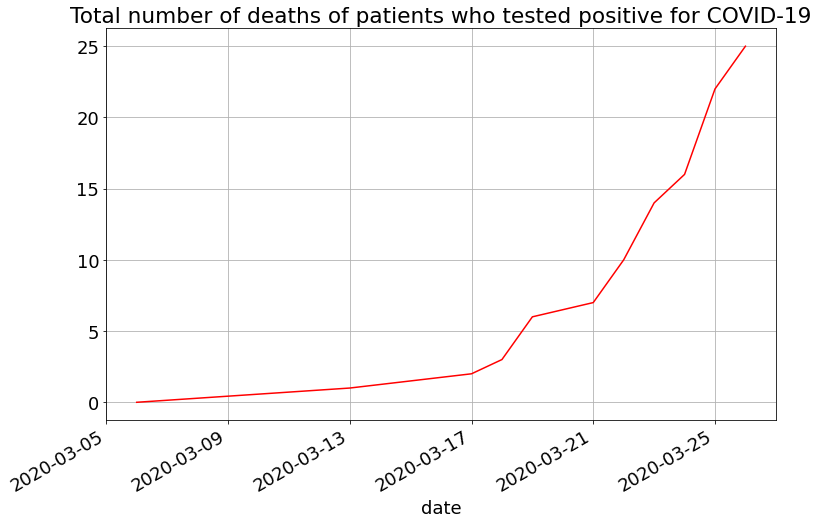

In [360]:
all_results.deaths.plot(color='r', title='Total number of deaths of patients who tested positive for COVID-19', grid=True, figsize=(12, 8))
plt.savefig('output/number_of_deaths_of_those_who_tested_positive.png')

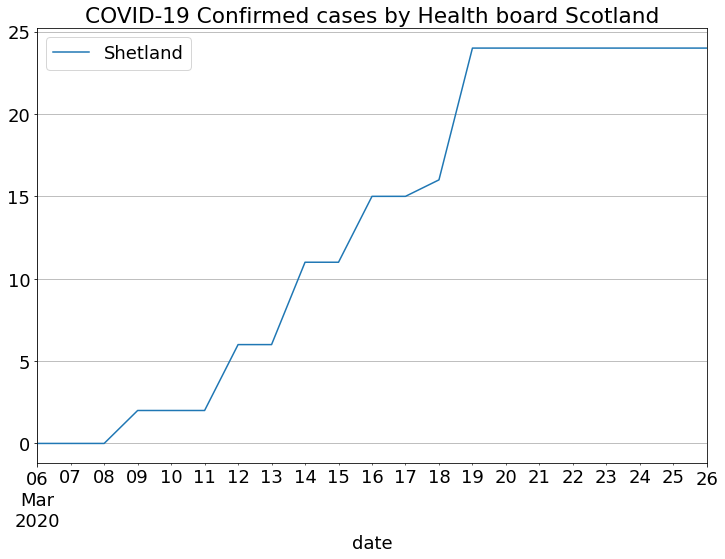

In [361]:
all_results.counts['Shetland'].plot(figsize=(12,8), title='COVID-19 Confirmed cases by Health board Scotland', grid=True, legend=True)
plt.savefig('output/confirmed_cases_by_health_board_time_series.png')

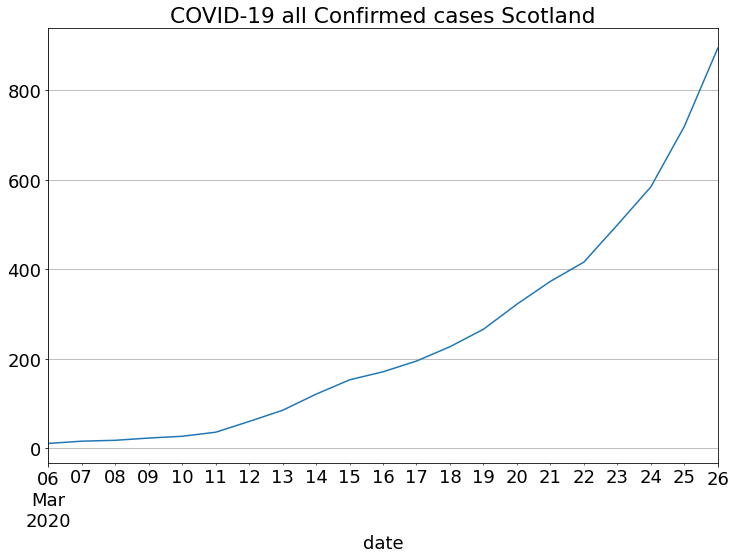

In [362]:
all_results.counts.sum(axis=1).plot(figsize=(12,8), title='COVID-19 all Confirmed cases Scotland', grid=True)
plt.savefig('output/all_confirmed_cases_time_series.png')

In [363]:
print("Daily increase of cases")
daily_increase_confirmed_cases = all_results.counts.sum(axis=1).diff()
daily_increase_confirmed_cases.to_csv('data/daily_increase_confirmed_cases.csv')

Daily increase of cases


In [364]:
print("Percentage of positive test daily")
percentage_of_positive_cases_daily = (all_results.counts.sum(axis=1).diff()/all_results.tests.diff() * 100)
percentage_of_positive_cases_daily.to_csv('data/percentage_of_positive_cases_daily')
print(percentage_of_positive_cases_daily)

Percentage of positive test daily
date
2020-03-06          NaN
2020-03-07     3.225806
2020-03-08     0.722022
2020-03-09     3.472222
2020-03-10     3.007519
2020-03-11    10.975610
2020-03-12     4.166667
2020-03-13     5.924171
2020-03-14     8.977556
2020-03-15     6.095238
2020-03-16     2.748092
2020-03-17     6.837607
2020-03-18     3.786982
2020-03-19     5.726872
2020-03-20     7.197943
2020-03-21     7.193230
2020-03-22    10.238095
2020-03-23    12.116788
2020-03-24    14.072848
2020-03-25    19.067797
2020-03-26    21.578298
dtype: float64


In [365]:
print("% increase cases across Scotland")
percentage_increase_cases_daily = round(all_results.counts.sum(axis=1).diff()/all_results.counts.sum(axis=1) * 100, 2)[1:]
percentage_increase_cases_daily.to_csv('data/percentage_increase_cases_daily.csv')
print(percentage_increase_cases_daily)

% increase cases across Scotland
date
2020-03-07    31.25
2020-03-08    11.11
2020-03-09    21.74
2020-03-10    14.81
2020-03-11    25.00
2020-03-12    40.00
2020-03-13    29.41
2020-03-14    29.75
2020-03-15    20.92
2020-03-16    10.53
2020-03-17    12.31
2020-03-18    14.10
2020-03-19    14.66
2020-03-20    17.39
2020-03-21    13.67
2020-03-22    10.34
2020-03-23    16.63
2020-03-24    14.55
2020-03-25    18.78
2020-03-26    19.57
dtype: float64


In [366]:
percentage_increases = ScotlandCOVID19.calculate_percentage_increases(all_results.counts)
percentage_increases_numbers = percentage_increases.copy()
percentage_increases = percentage_increases.replace(100,'First Case Confirmed')
new_columns = []
for p_increases in percentage_increases.columns:
    new_columns.append(str(p_increases)[:10])
percentage_increases.columns = new_columns
output_file_name = 'daily_percentage_increase_by_health_board'
percentage_increases.to_csv('data/' + output_file_name + '.csv')
md = open('output/' + output_file_name + '.md','w')
md.write(tabulate(percentage_increases, tablefmt="pipe", headers="keys"))
md.close()

In [367]:
min_days_present = (~percentage_increases.isna()).sum(axis=1)
min_days_present.name = 'Minimum number of days of confirmed cases since 6th March'
min_days_present.to_csv('data/minimum_days_present.csv')
min_days_present

Health Board
Ayrshire and Arran           20
Borders                      16
Dumfries and Galloway        11
Fife                         20
Forth Valley                 20
Grampian                     20
Greater Glasgow and Clyde    20
Highland                     13
Lanarkshire                  20
Lothian                      20
Shetland                     18
Tayside                      20
Name: Minimum number of days of confirmed cases since 6th March, dtype: int64

In [368]:
print("Warning there is a varying time period for each Health board, see cell above minimum days present")
mean_daily_percent_increase_by_board = round(
    percentage_increases.mean(axis=1), 2)
mean_daily_percent_increase_by_board.name = "Mean % increase 6-" + str(datetime.now())[8:10] + "th March"
mean_daily_percent_increase_by_board.sort_values(inplace=True)
mean_daily_percent_increase_by_board.to_csv('data/mean_daily_percent_increase_by_board.csv')
print(mean_daily_percent_increase_by_board)
mean_daily_percent_increase_by_board.mean().round(2)

Warning there is a varying time period for each Health board, see cell above minimum days present
Health Board
Shetland                      7.59
Tayside                      12.03
Grampian                     12.04
Borders                      12.90
Ayrshire and Arran           15.07
Fife                         15.25
Lanarkshire                  15.79
Lothian                      17.86
Forth Valley                 19.10
Greater Glasgow and Clyde    21.18
Highland                     23.43
Dumfries and Galloway        26.87
Name: Mean % increase 6-26th March, dtype: float64


16.59

In [369]:
all_results

            Deaths of confirmed cases  Tests concluded
date                                                  
2020-03-06                        0.0             1525
2020-03-07                        NaN             1680
2020-03-08                        NaN             1957
2020-03-09                        NaN             2101
2020-03-10                        NaN             2234
2020-03-11                        NaN             2316
2020-03-12                        NaN             2892
2020-03-13                        1.0             3314
2020-03-14                        NaN             3715
2020-03-15                        NaN             4240
2020-03-16                        NaN             4895
2020-03-17                        2.0             5246
2020-03-18                        3.0             6091
2020-03-19                        6.0             6772
2020-03-20                        NaN             7550
2020-03-21                        7.0             8259
2020-03-22

In [382]:
daily_percent_increase_deaths = ((all_results.deaths.diff()/all_results.deaths) * 100).round(2).iloc[2:]

In [383]:
daily_percent_increase_deaths

date
2020-03-17    50.00
2020-03-18    33.33
2020-03-19    50.00
2020-03-21    14.29
2020-03-22    30.00
2020-03-23    28.57
2020-03-24    12.50
2020-03-25    27.27
2020-03-26    12.00
Name: Deaths of confirmed cases, dtype: float64

In [384]:
daily_percent_increase_deaths.name = 'Daily % increase deaths of confirmed cases'

In [385]:
daily_percent_increase_deaths.mean()

28.662222222222226

## Linking Council areas to Health Boards to quantify cases in terms of population

In [386]:
council_areas, health_board_to_council = ScotlandCOVID19.get_council_areas_and_relationship_to_health_board()

In [387]:
scottish_population = council_areas.sum()[1]

In [388]:
percentage_population_tested = all_results.tests/scottish_population*100

In [389]:
percentage_population_tested
percentage_population_tested.to_csv('percentage_population_tested.csv')
percentage_population_tested

date
2020-03-06    0.028043
2020-03-07    0.030893
2020-03-08    0.035987
2020-03-09    0.038635
2020-03-10    0.041081
2020-03-11    0.042588
2020-03-12    0.053180
2020-03-13    0.060940
2020-03-14    0.068314
2020-03-15    0.077968
2020-03-16    0.090013
2020-03-17    0.096468
2020-03-18    0.112006
2020-03-19    0.124529
2020-03-20    0.138835
2020-03-21    0.151873
2020-03-22    0.159596
2020-03-23    0.172192
2020-03-24    0.183299
2020-03-25    0.196319
2020-03-26    0.211232
Name: Tests concluded, dtype: float64

In [390]:
council_areas = council_areas.loc[council_areas.index.sort_values()]

In [391]:
health_board_to_council.set_index(health_board_to_council.columns[0], inplace=True)
health_board_to_council.rename({'Council areas':'council_areas'}, axis=1, inplace=True)
health_board_to_council = health_board_to_council.council_areas.str.rsplit(' and ',1, expand=True)

In [392]:
# Forth Valley
health_board_to_council.iloc[4].name = health_board_to_council.iloc[4].name.rsplit(' ', 5)[0]

Splitting on final ' and ' above create issues for the following areas

In [393]:
# Handle Perth and Kinross
health_board_to_council.loc['Tayside'].iloc[1] = health_board_to_council.loc['Tayside'].iloc[1].split(' and ')[0]
health_board_to_council.loc['Tayside'].iloc[-1] = 'Perth and Kinross'

In [394]:
# Handle Dumfries and Galloway
health_board_to_council.iloc[2][0] = health_board_to_council.iloc[2].name

In [395]:
health_board_to_council = health_board_to_council.iloc[:,0].str.split(', ', expand=True).join(health_board_to_council.iloc[:,1], rsuffix='_1')

In [396]:
health_board_to_council.loc['Dumfries and Galloway'][-1] = None

In [397]:
# Use council area naming
health_board_to_council.iloc[-1][0] = 'Na h-Eileanan Siar (Western Isles)'

In [398]:
# Drop the Forth Valley suffix
health_board_to_council.rename({health_board_to_council.index[4]: health_board_to_council.index[4].rsplit(' ', 5)[0]}, inplace=True)

In [399]:
# Handle Perth and Kinross
health_board_to_council.loc['Tayside'].iloc[1] = health_board_to_council.loc['Tayside'].iloc[1].split(' and ')[0]
health_board_to_council.loc['Tayside'].iloc[-1] = 'Perth and Kinross'

In [400]:
health_board_populations = ScotlandCOVID19.get_population_for_health_board(health_board_to_council, council_areas)

In [401]:
health_board_populations.rename({'Western Isles (Eileanan Siar)':'Western Isles'}, inplace=True)

In [402]:
reload(ScotlandCOVID19)

<module 'ScotlandCOVID19' from '/home/jamesmorrison/Scotland_COVID-19/ScotlandCOVID19.py'>

In [403]:
population_data, weighted_density = ScotlandCOVID19.get_population_and_density_for_health_board_by_council(health_board_to_council, council_areas)

In [404]:
weighted_density = pd.Series(weighted_density)

In [405]:
weight_density_counts = pd.concat([all_results.counts.iloc[-1], weighted_density, percentage_confirmed_cases_by_health_board_population],axis=1)
weight_density_counts.columns = ['Confirmed Cases', 'Weighted population density', 'percentage_confirmed_cases_by_health_board_population']

In [ ]:
all_results

In [443]:
all_results.counts['Western Isles'] = 0
all_results.counts['Orkney'] = 0

In [ ]:
health_board_geo_df

In [444]:
weight_density_counts

,Confirmed Cases,Weighted population density,percentage_confirmed_cases_by_health_board_population
Ayrshire and Arran,74.0,115.970785,0.015
Borders,23.0,24.000000,0.013
Dumfries and Galloway,39.0,23.000000,0.021
Fife,40.0,281.000000,0.008
Forth Valley,75.0,349.859999,0.019
Grampian,31.0,502.247250,0.005
Greater Glasgow and Clyde,258.0,2191.101287,0.019
Highland,29.0,9.804164,0.007
Lanarkshire,114.0,460.731068,0.013
Lothian,111.0,1268.239193,0.010


In [408]:
total_deaths = all_results.deaths.resample('d').first().ffill()

In [409]:
print("Case fatality rate %")
(total_deaths/all_results.tests)*100

Case fatality rate %


date
2020-03-06    0.000000
2020-03-07    0.000000
2020-03-08    0.000000
2020-03-09    0.000000
2020-03-10    0.000000
2020-03-11    0.000000
2020-03-12    0.000000
2020-03-13    0.030175
2020-03-14    0.026918
2020-03-15    0.023585
2020-03-16    0.020429
2020-03-17    0.038124
2020-03-18    0.049253
2020-03-19    0.088600
2020-03-20    0.079470
2020-03-21    0.084756
2020-03-22    0.115221
2020-03-23    0.149509
2020-03-24    0.160514
2020-03-25    0.206070
2020-03-26    0.217637
Freq: D, dtype: float64

In [410]:
weight_density_counts = weight_density_counts.fillna(0).iloc[:-1]

In [411]:
weight_density_counts

,Confirmed Cases,Weighted population density,percentage_confirmed_cases_by_health_board_population
Ayrshire and Arran,74.0,115.970785,0.015
Borders,23.0,24.000000,0.013
Dumfries and Galloway,39.0,23.000000,0.021
Fife,40.0,281.000000,0.008
Forth Valley,75.0,349.859999,0.019
Grampian,31.0,502.247250,0.005
Greater Glasgow and Clyde,258.0,2191.101287,0.019
Highland,29.0,9.804164,0.007
Lanarkshire,114.0,460.731068,0.013
Lothian,111.0,1268.239193,0.010


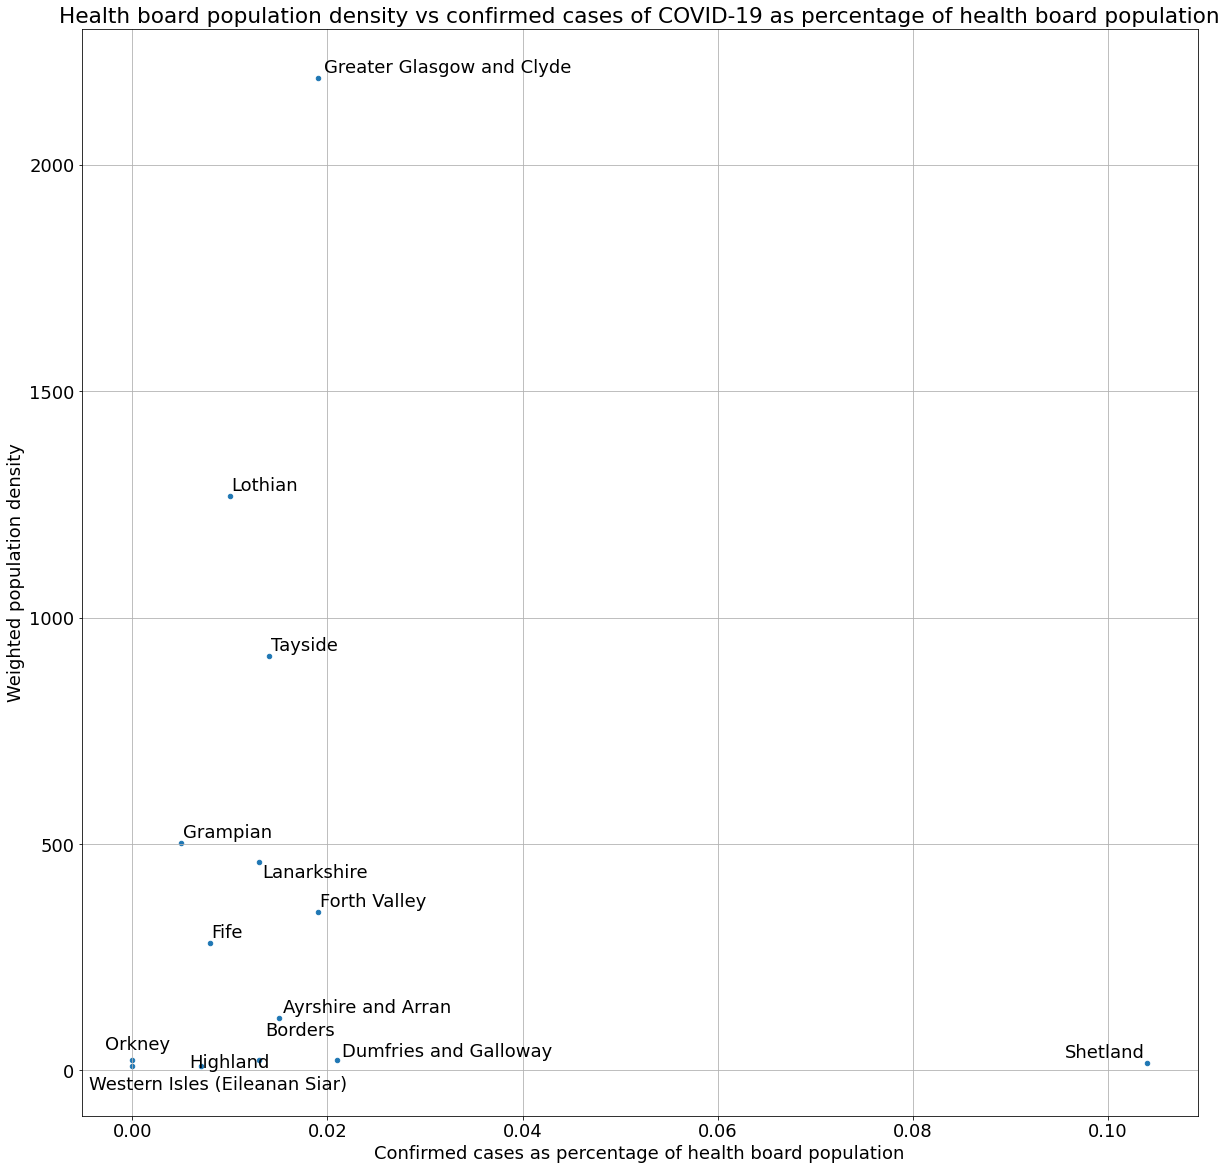

In [412]:
axes = weight_density_counts.plot.scatter(
    figsize=(20,20),
    x='percentage_confirmed_cases_by_health_board_population', y='Weighted population density')
#axes.set_yscale('log')
#axes.set_xscale('log')
#axes.set_xlim(0,np.log10(weight_density_counts['Weighted population density'].max()))
texts = []
for health_board, data in weight_density_counts.iterrows():
    texts.append(axes.text(s=health_board, x=data['percentage_confirmed_cases_by_health_board_population'], y=data['Weighted population density']))
adjust_text(texts)
axes.set_xlabel('Confirmed cases as percentage of health board population')
plt.title("Health board population density vs confirmed cases of COVID-19 as percentage of health board population")
plt.grid()
plt.savefig('output/pop_density_vs_confirmed_cases_as_percentage_of_health_board_population.png')

In [413]:
print("Population density divided by Confirmed Cases")
print(weight_density_counts.iloc[:,1]/weight_density_counts.iloc[:,0].fillna(0).sort_values(ascending=False))

Population density divided by Confirmed Cases
Ayrshire and Arran                1.567173
Borders                           1.043478
Dumfries and Galloway             0.589744
Fife                              7.025000
Forth Valley                      4.664800
Grampian                         16.201524
Greater Glasgow and Clyde         8.492641
Highland                          0.338075
Lanarkshire                       4.041501
Lothian                          11.425578
Orkney                                 inf
Shetland                          0.666667
Tayside                          12.027357
Western Isles (Eileanan Siar)          inf
dtype: float64


In [414]:
from adjustText import adjust_text

In [415]:
last_counts = all_results.counts.iloc[-1]

In [416]:
percentage_confirmed_cases_by_health_board_population = (last_counts / health_board_populations * 100).sort_values(ascending=False).fillna(0).round(3)
print("Percentage of confirmed cases in population by health board")
print(percentage_confirmed_cases_by_health_board_population)
percentage_confirmed_cases_by_health_board_population.to_csv('data/percentage_confirmed_cases_by_health_board_population.csv')

Percentage of confirmed cases in population by health board
Shetland                         0.104
Dumfries and Galloway            0.026
Forth Valley                     0.025
Greater Glasgow and Clyde        0.022
Ayrshire and Arran               0.020
Borders                          0.020
Tayside                          0.018
Lanarkshire                      0.017
Lothian                          0.012
Fife                             0.011
Highland                         0.009
Grampian                         0.005
Orkney                           0.000
Western Isles                    0.000
Western Isles (Eileanan Siar)    0.000
dtype: float64


In [417]:
health_board_to_council.to_csv('data/health_board_to_council.csv')

In [418]:
council_areas.to_csv('data/council_areas.csv')

In [419]:
health_boards = gpd.read_file('gis/scottish_health_boards.gpkg', layer='scottish_health_boards')

In [420]:
health_boards.set_index('Name', inplace=True)

In [421]:
health_board_name_mapping = {
    'Aberdeen City': 'Grampian',
    'Clackmannanshire': 'Forth Valley',
    'Dundee City': 'Tayside',
    'East Ayrshire': 'Ayrshire and Arran',
    'East Dunbartonshire': 'Greater Glasgow and Clyde',
    'Midlothian': 'Lothian',
    'Na h-Eileanan an Iar': 'Western Isles',
    'Orkney Islands': 'Orkney',
    'Scottish Borders': 'Borders',
    'Shetland Islands': 'Shetland',
    'South Lanarkshire': 'Lanarkshire'
}

In [422]:
# Ensure naming is consistent with names used on Scottish Government COVID-19 page
health_boards.rename(health_board_name_mapping, inplace=True)

In [423]:
health_board_geo_series = health_boards.geometry

In [424]:
health_board_geo_series = health_board_geo_series[health_board_geo_series.index.sort_values()]

In [425]:
simplified_health_boards = health_board_geo_series.simplify(50)

In [426]:
all_recent_counts = ScotlandCOVID19.get_all_recent_counts(all_results)

In [427]:
health_board_geo_df = gpd.GeoDataFrame(all_recent_counts, geometry=simplified_health_boards.geometry)

In [428]:
date = str(all_results.counts.index[-1])[:10]

In [429]:
health_board_geo_df.rename({0: date}, axis=1, inplace=True)

In [430]:
matplotlib.rcParams.update({"font.size": 18})

In [431]:
percentage_confirmed_cases_of_health_board_population = (health_board_geo_df.iloc[:,0]/health_board_populations) * 100

In [432]:
percentage_confirmed_cases_of_health_board_population_geo_df = gpd.GeoDataFrame(percentage_confirmed_cases_of_health_board_population, geometry=simplified_health_boards.geometry)

In [433]:
percentage_confirmed_cases_of_health_board_population_geo_df

,0,geometry
Ayrshire and Arran,0.020018,"MULTIPOLYGON (((201916.200 600444.404, 202189...."
Borders,0.019953,"POLYGON ((304665.500 614182.601, 304478.997 61..."
Dumfries and Galloway,0.026211,"MULTIPOLYGON (((300762.200 557416.309, 300592...."
Fife,0.010755,"MULTIPOLYGON (((345119.801 729394.303, 345768...."
Forth Valley,0.024504,"POLYGON ((278764.300 678216.902, 278386.800 67..."
Grampian,0.005303,"MULTIPOLYGON (((383521.198 771234.696, 383536...."
Greater Glasgow and Clyde,0.021958,"POLYGON ((250331.100 650306.001, 249983.199 65..."
Highland,0.009012,"MULTIPOLYGON (((173254.001 604986.004, 173377...."
Lanarkshire,0.017294,"POLYGON ((304665.500 614182.601, 303783.501 61..."
Lothian,0.012364,"MULTIPOLYGON (((313763.397 679505.003, 313604...."


In [434]:
# Following section inspired by
# https://towardsdatascience.com/how-to-make-a-gif-map-using-python-geopandas-and-matplotlib-cd8827cefbc8

In [480]:
def plot_log10_daily_count_maps(
        counts: pd.DataFrame, figsize=(15,18), ticks: list = [0, 15, 30, 65, 130, 260],
        colorbar_label: str = 'Number of confirmed COVID-19 cases in health board') -> None:
    """Iterate over daily count data producing a GeoDataFrame and plotting it log10"""
    results = np.log10(counts)
    maximum = results.max().max()
    for index, row in results.iterrows():
        row[row < 0] = 0
        output = gpd.GeoDataFrame(row, geometry=health_board_geo_df.geometry).plot(
            column=row.name, vmin=0, vmax=np.log10(ticks[-1]), figsize=figsize)
        output.set_title(str(row.name)[:10])
        output.axis('off')
        cbar = plt.colorbar(output.collections[0])
        cbar.set_ticks([np.log10(num) for num in ticks])
        cbar.set_ticklabels([str(num) for num in ticks])
        cbar.set_label(colorbar_label)
        plt.savefig('output/' + str(row.name)[:10])

In [465]:
health_board_geo_df.drop_duplicates(inplace=True)

/home/jamesmorrison/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log10
  """
/home/jamesmorrison/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in log10
  
/home/jamesmorrison/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in log10
  
/home/jamesmorrison/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in log10
  
/home/jamesmorrison/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in log10
  
/home/jamesmorrison/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in log10
  
/home/jamesmorrison/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in log10
  
/home/jamesmorriso

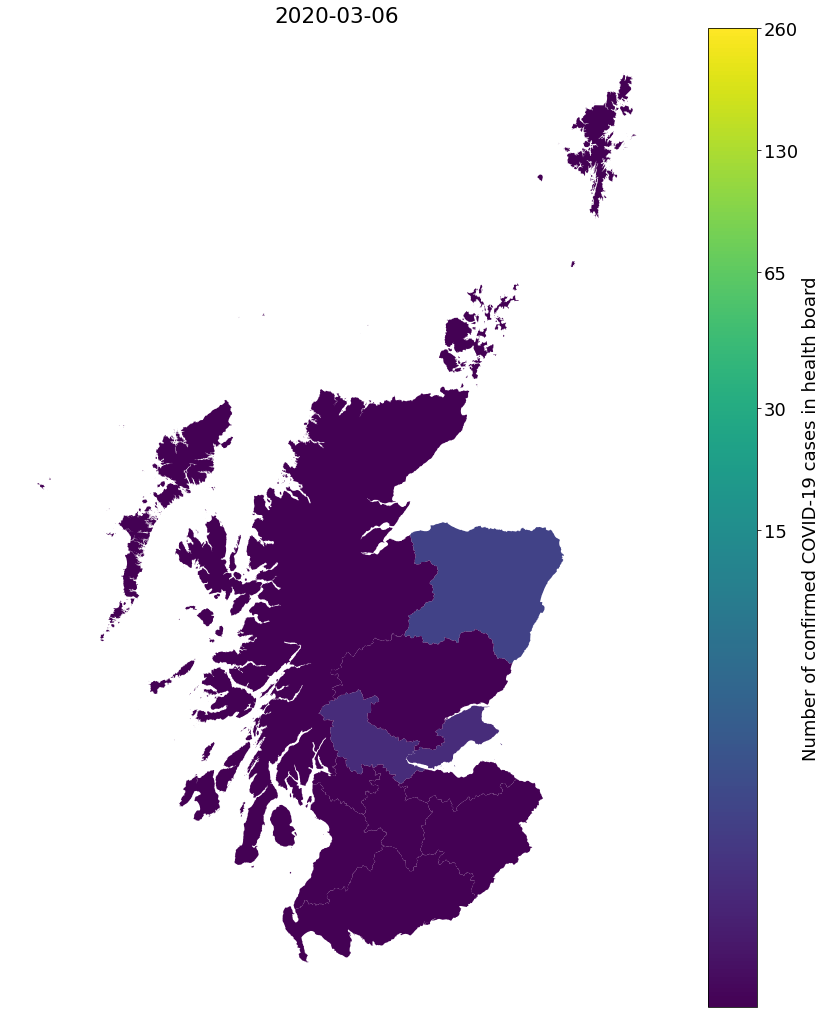

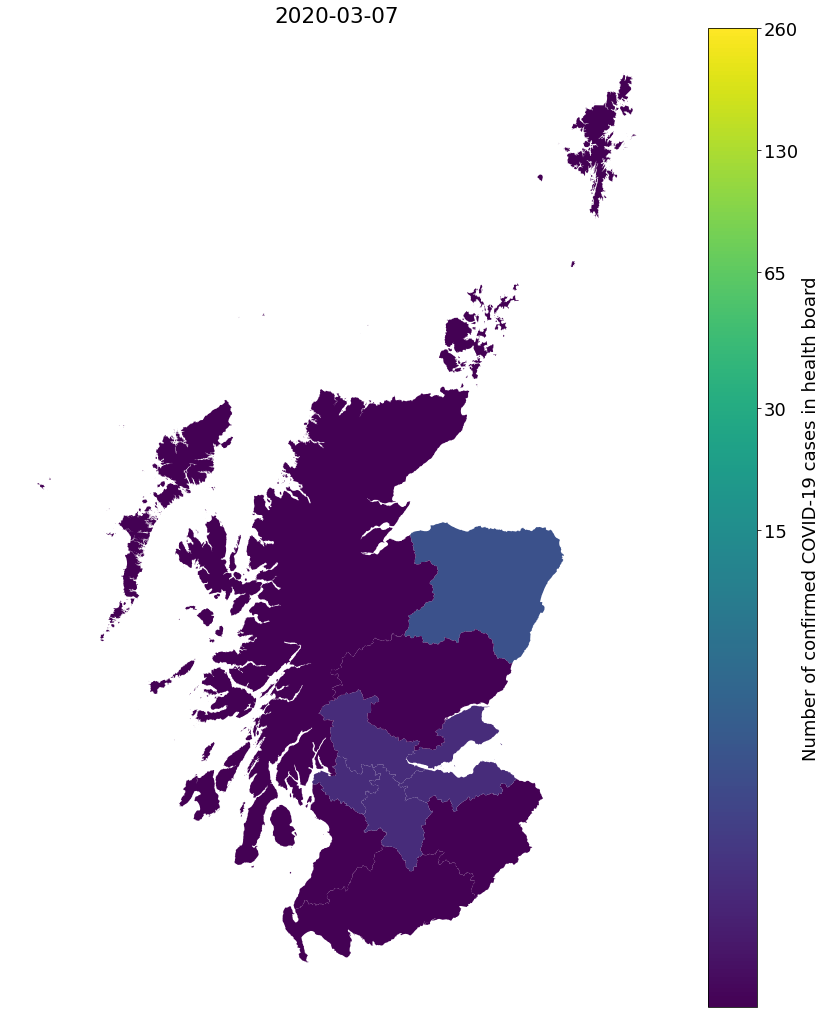

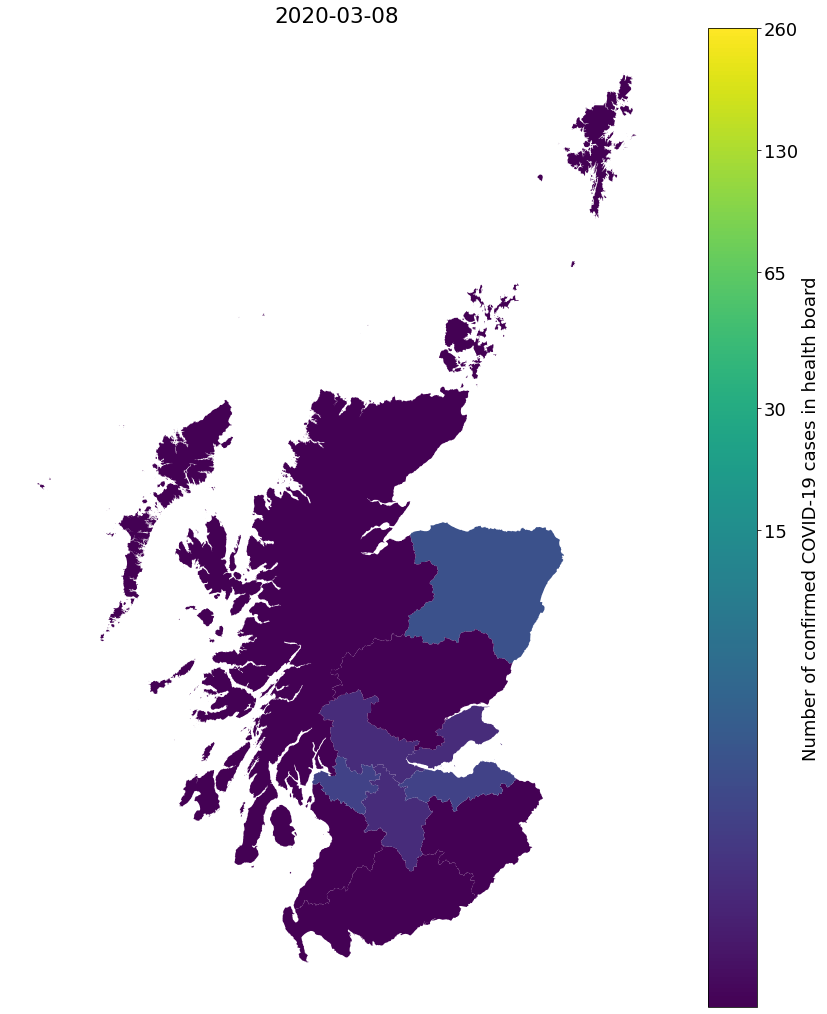

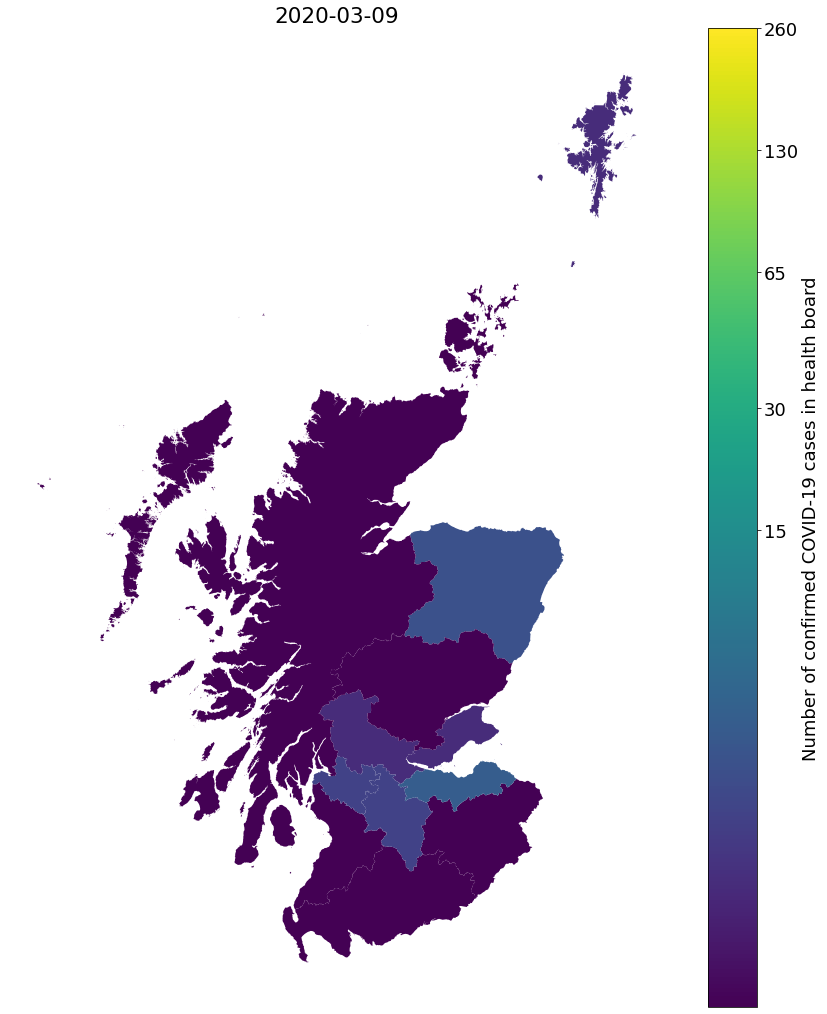

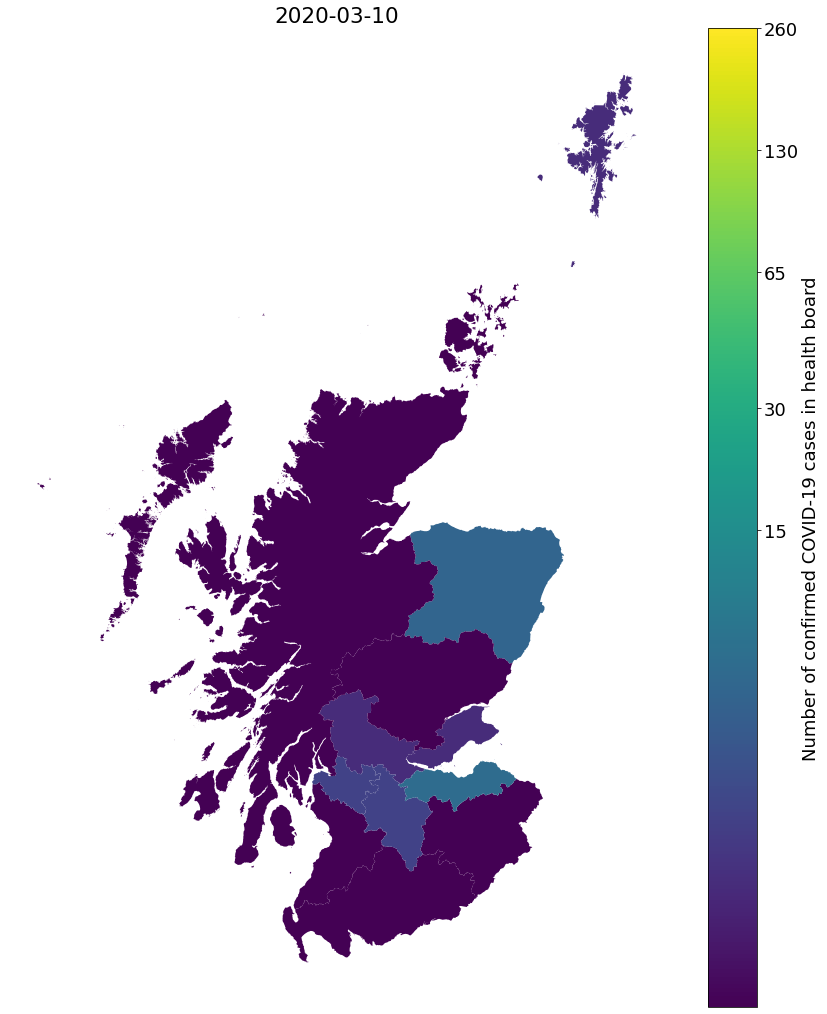

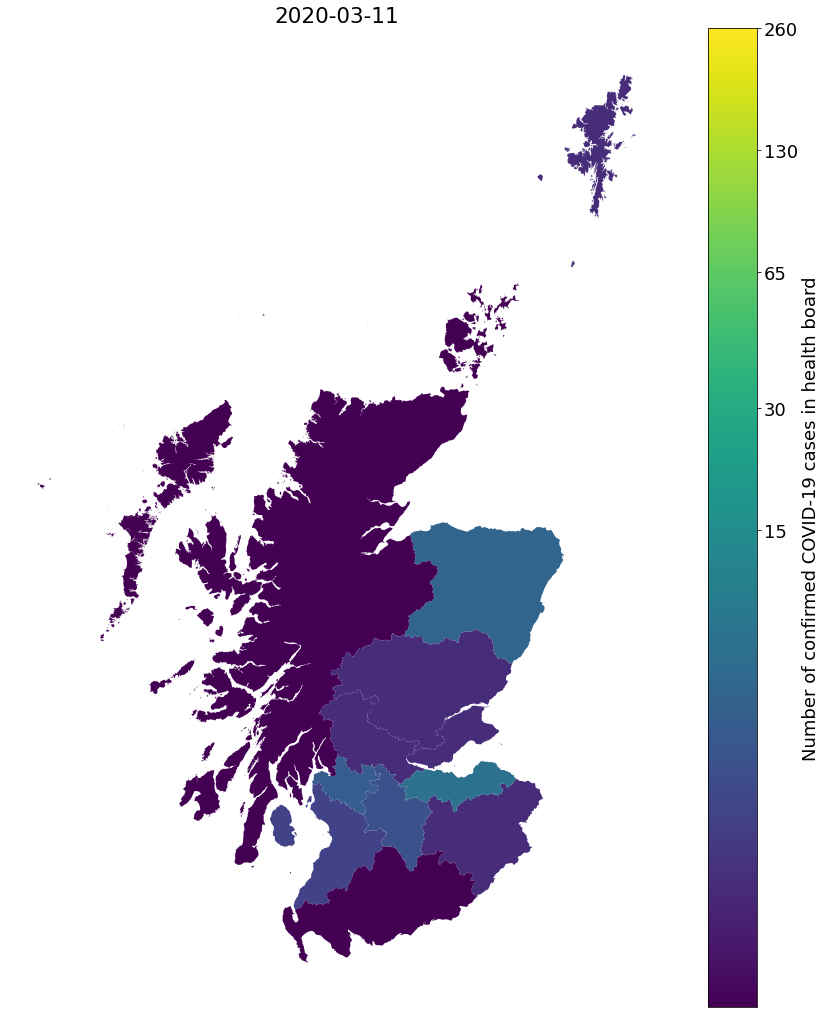

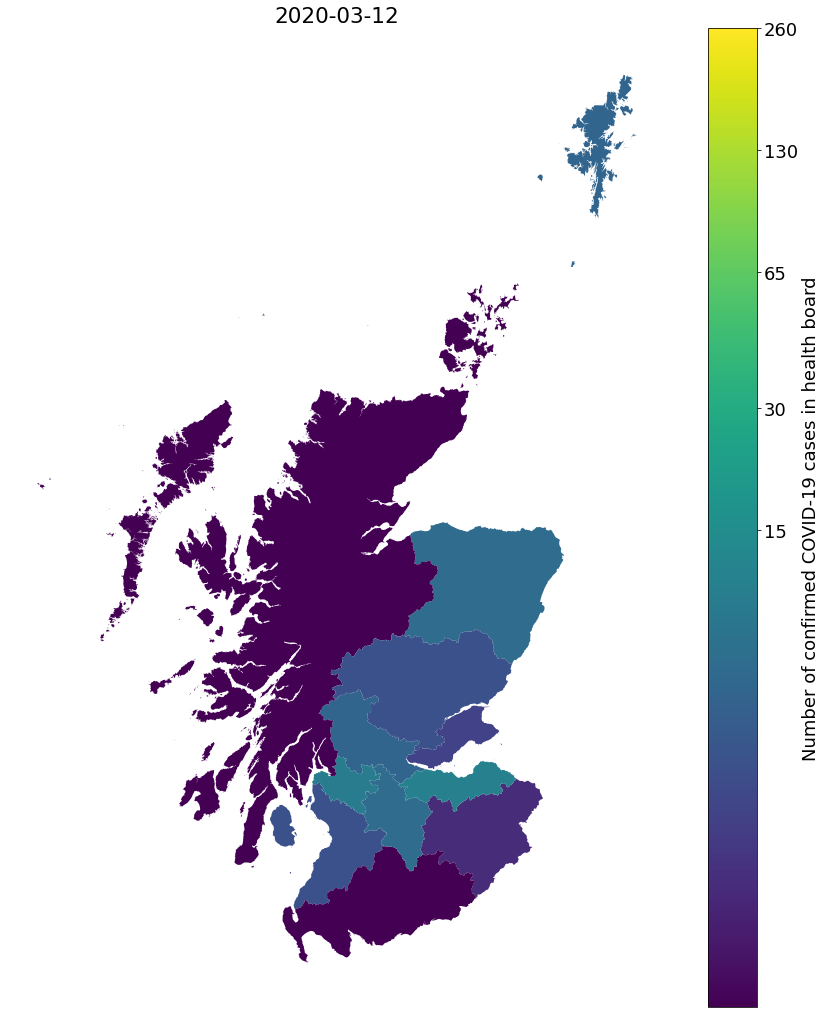

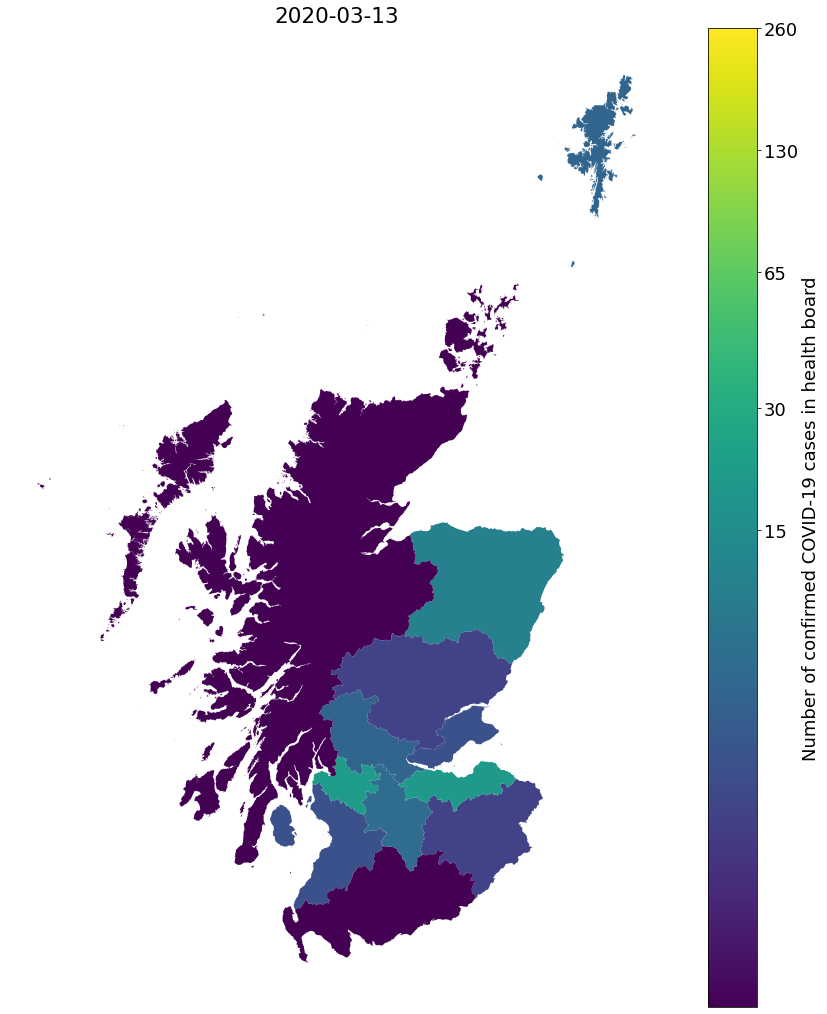

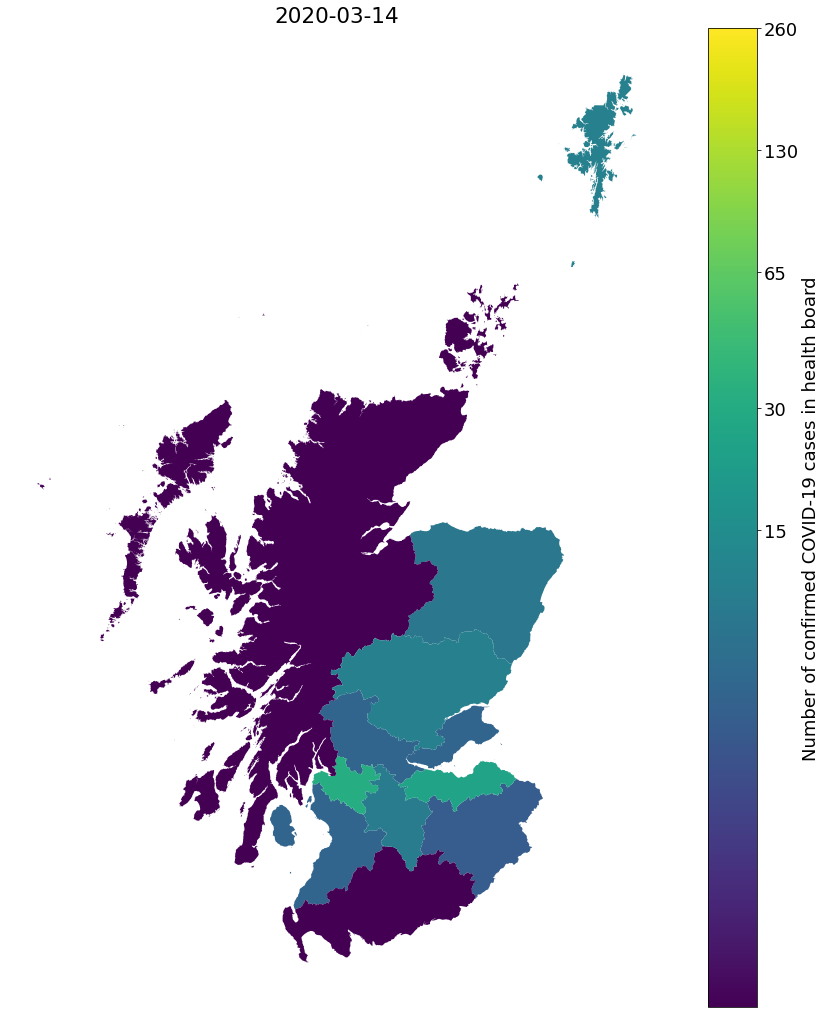

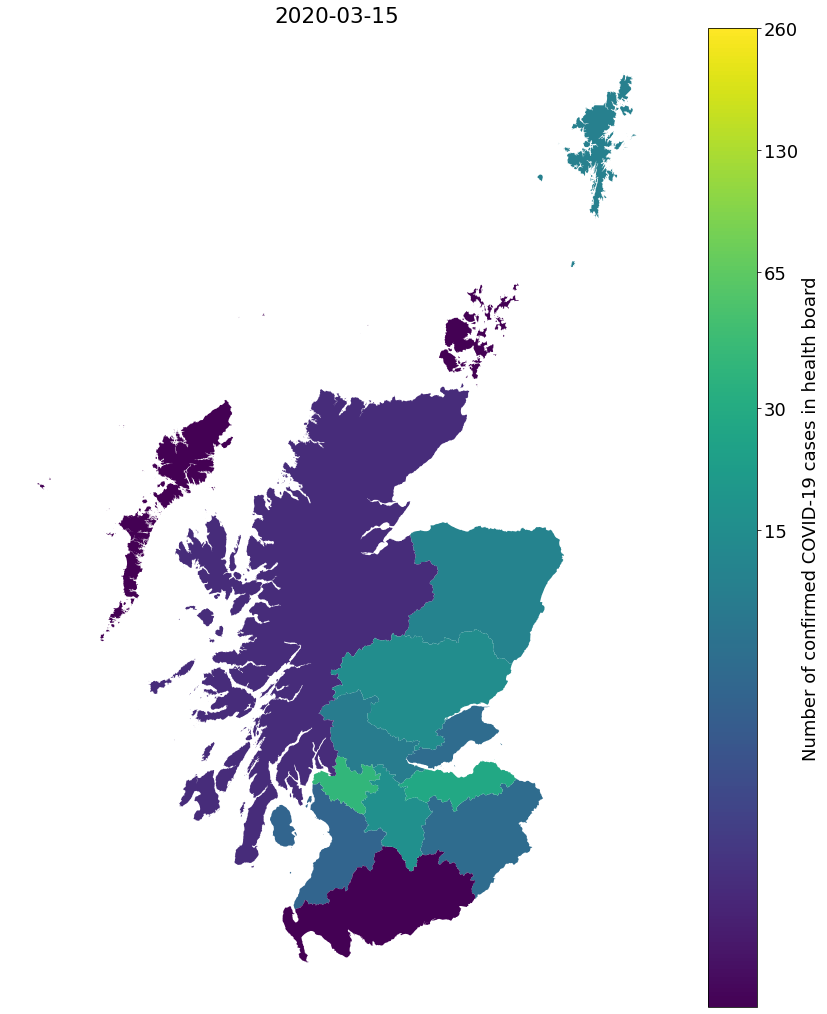

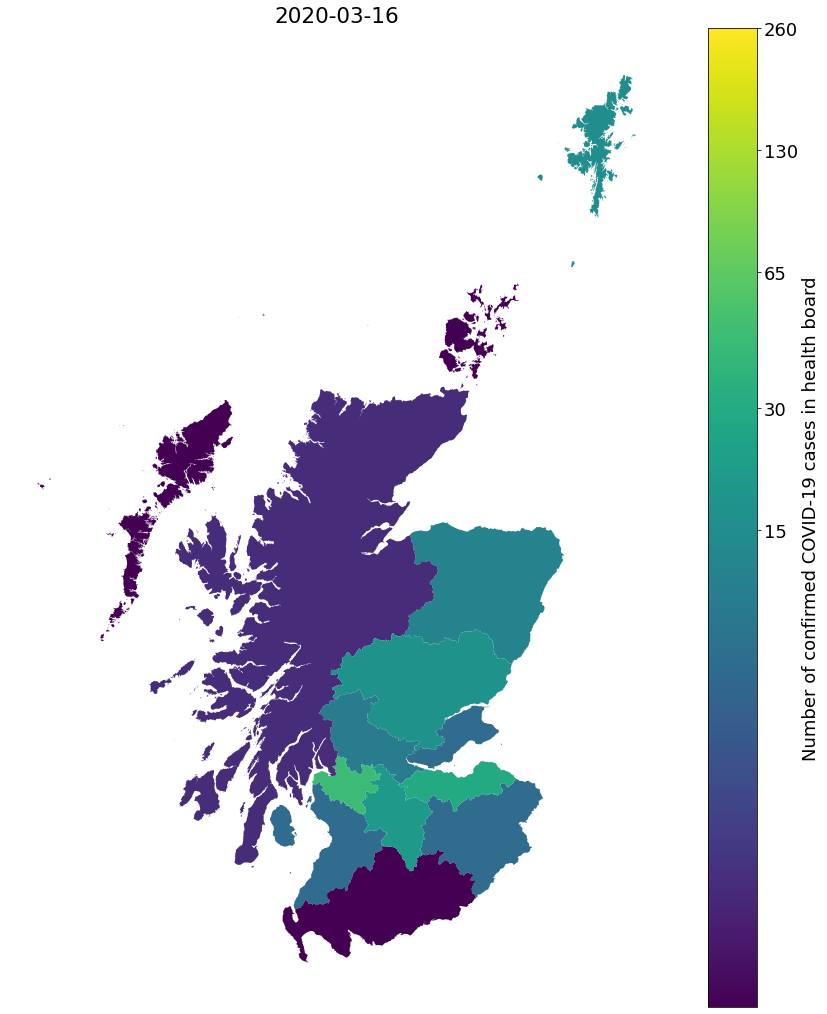

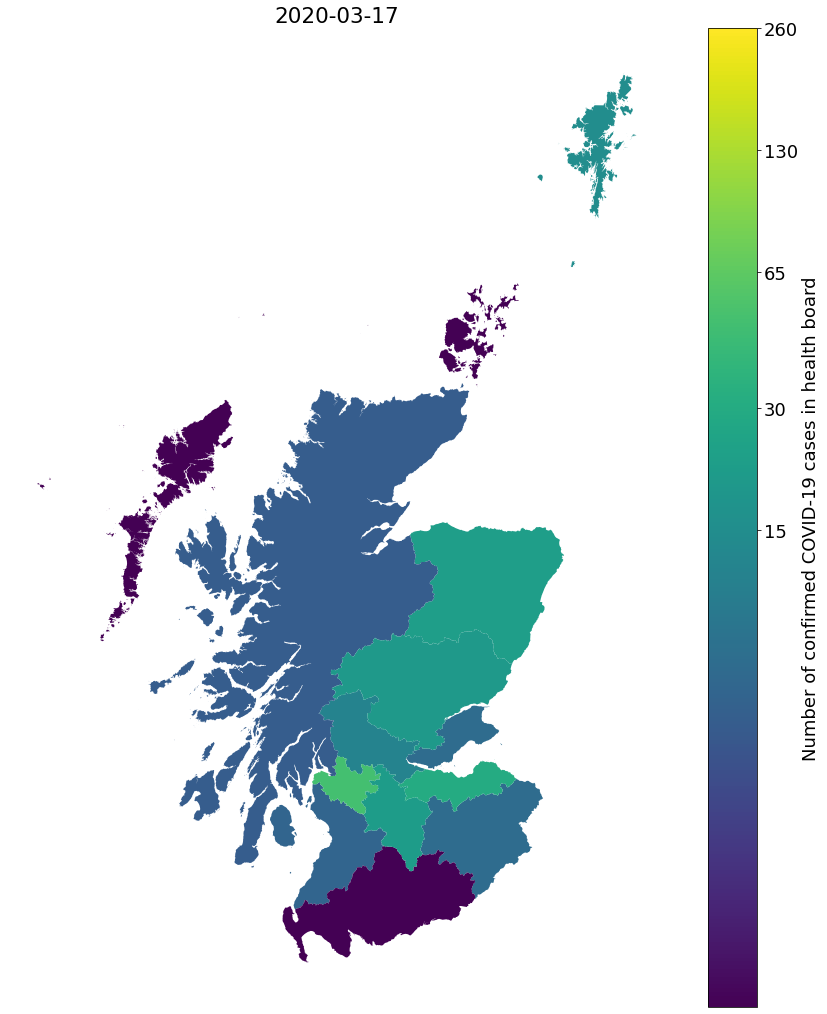

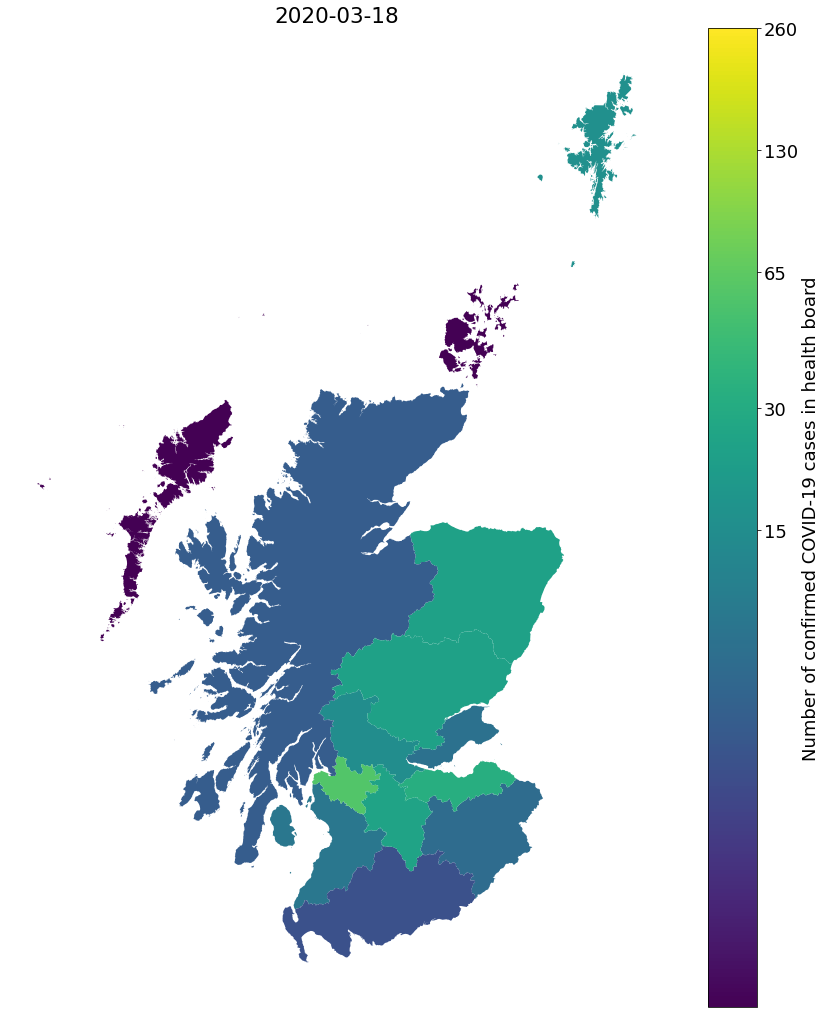

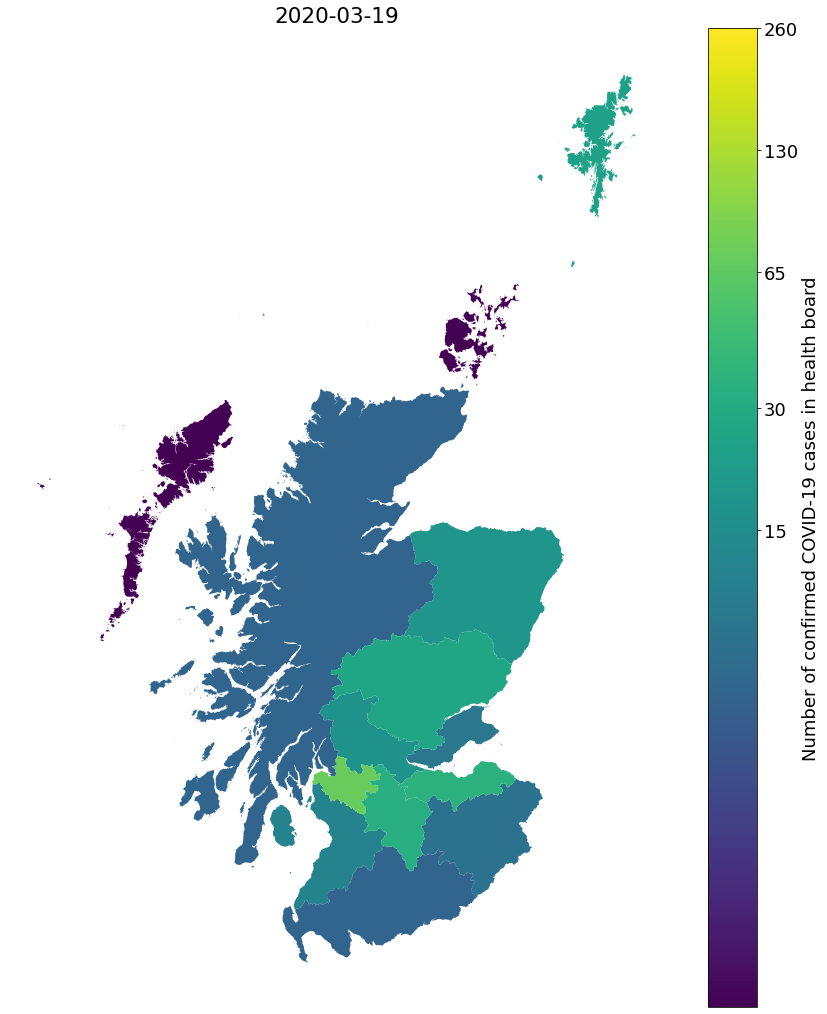

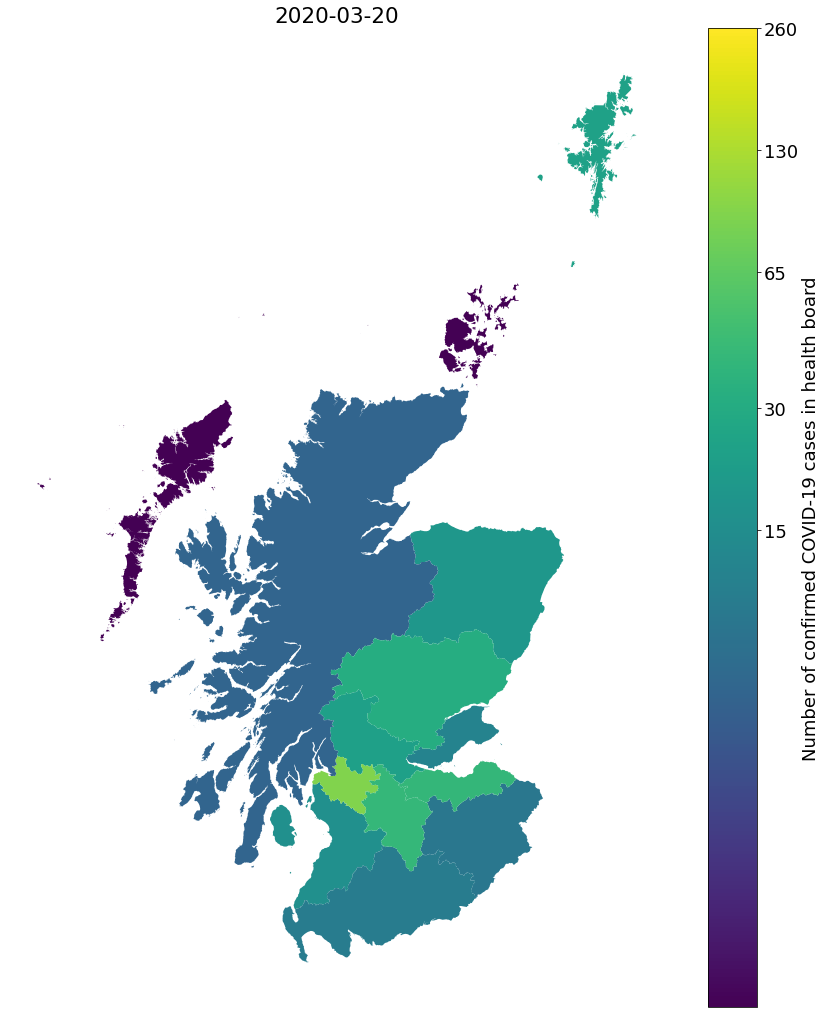

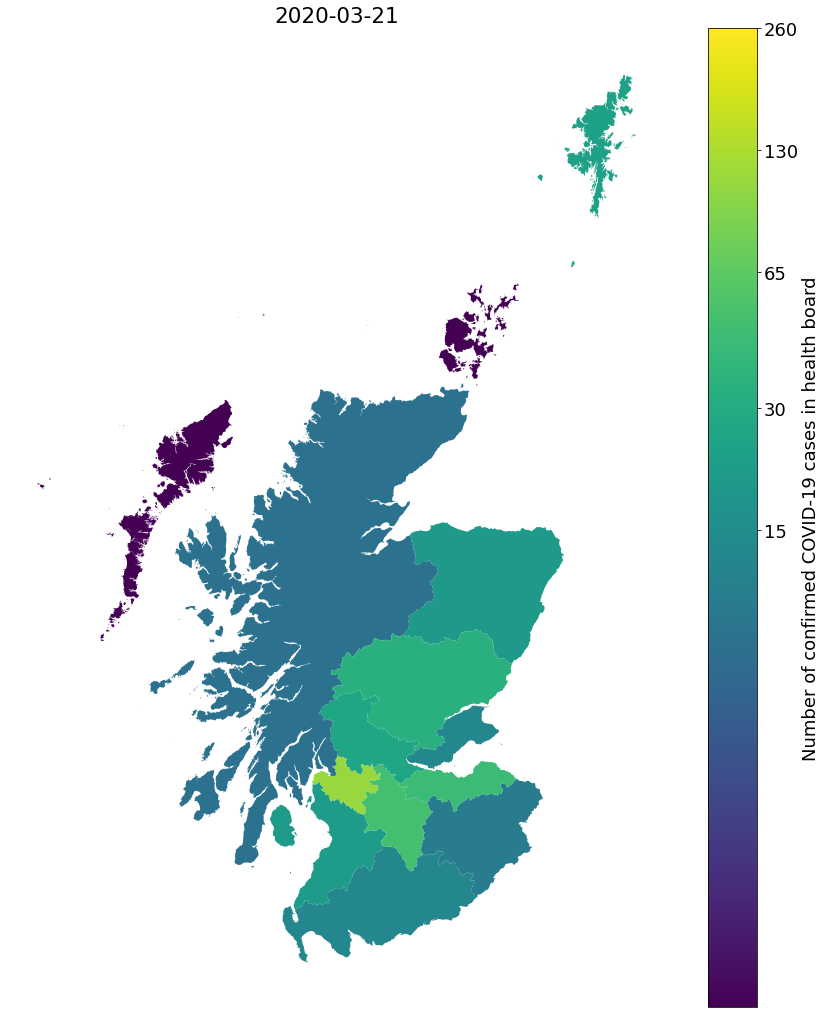

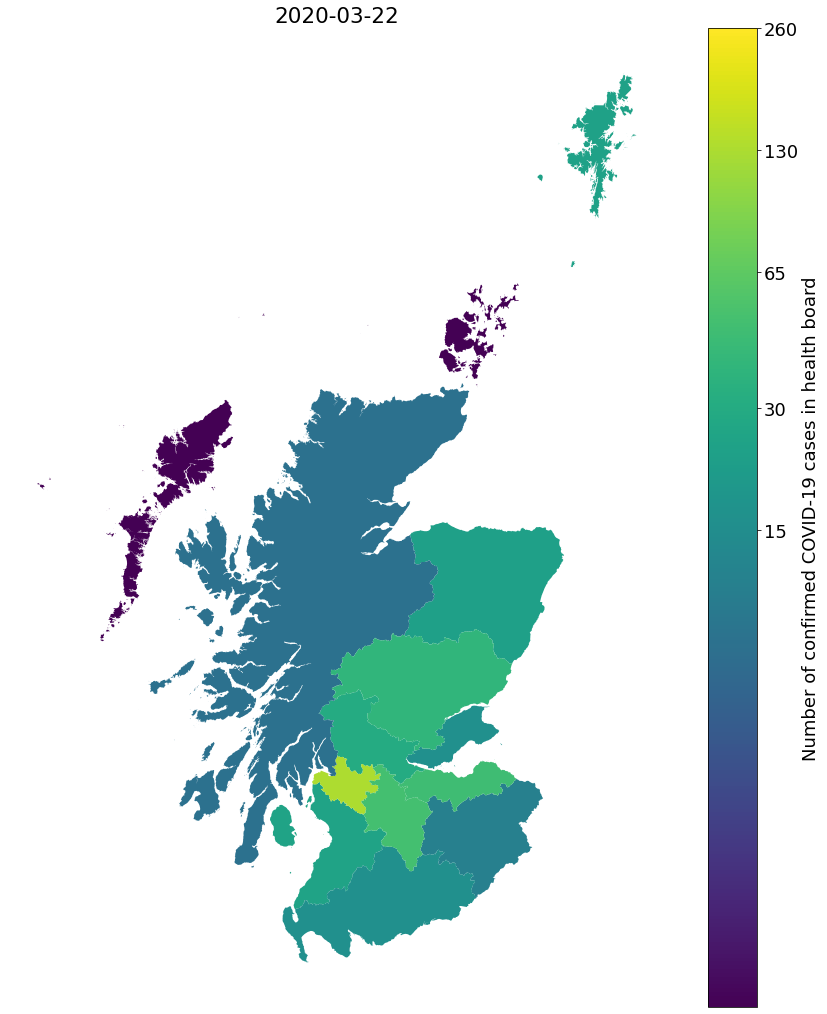

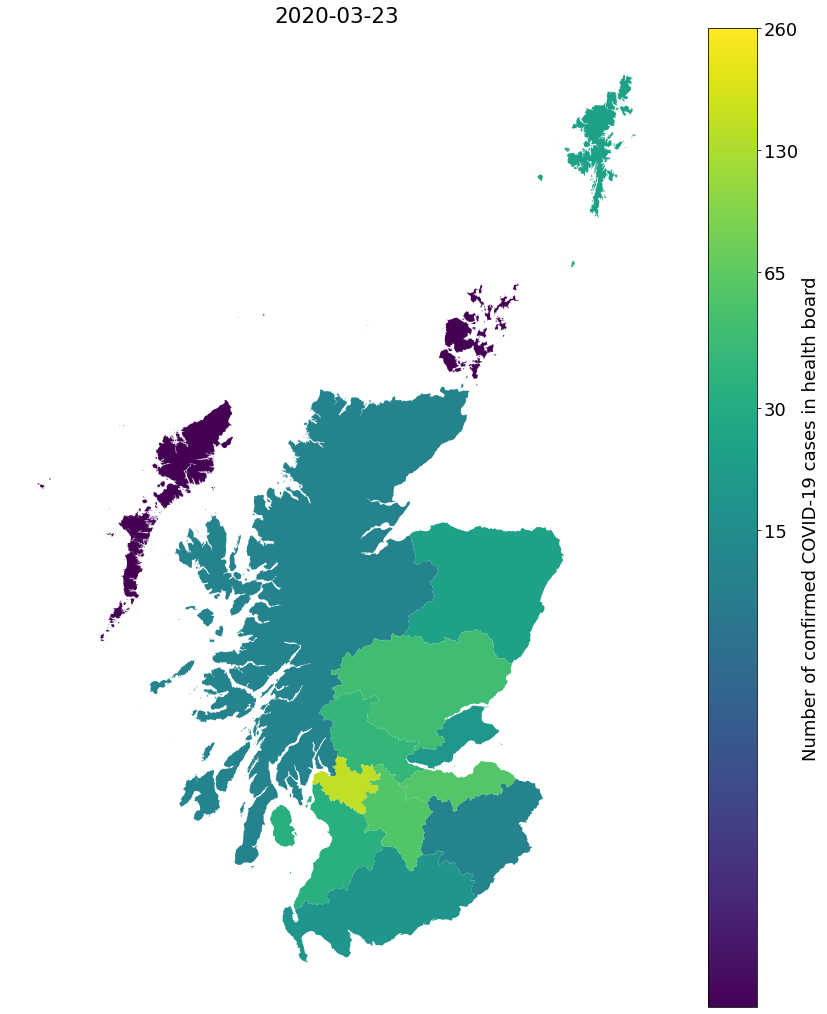

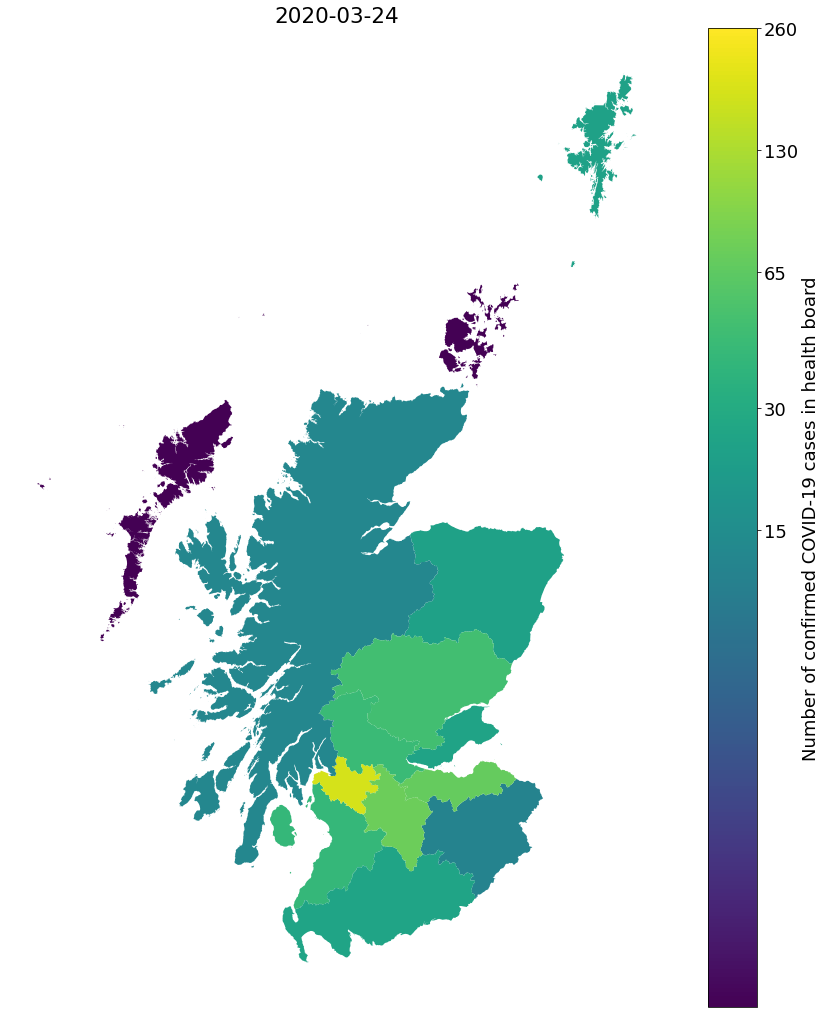

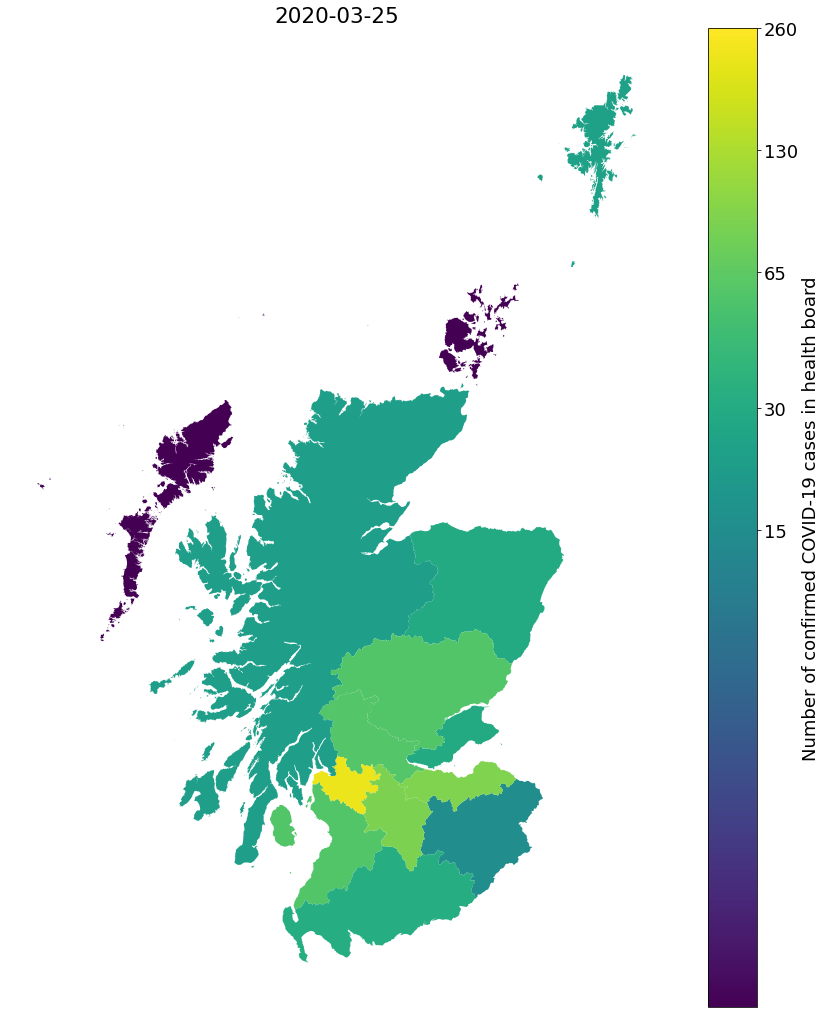

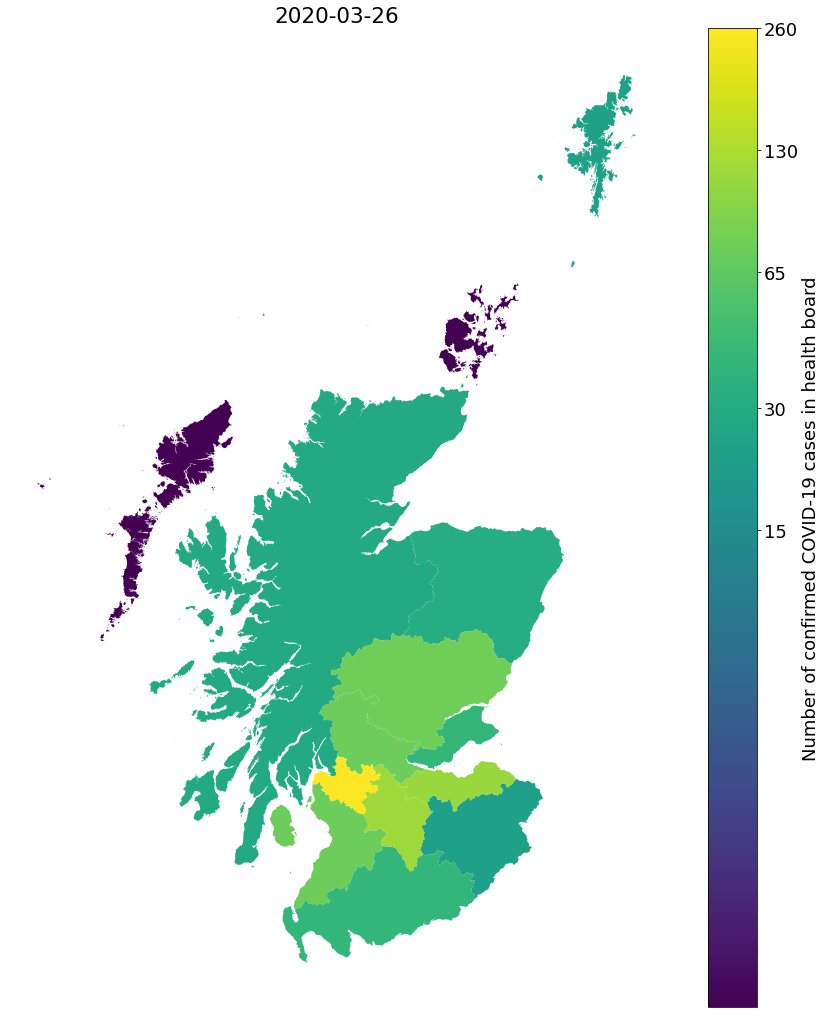

In [481]:
plot_log10_daily_count_maps(all_results.counts)

In [341]:
# Cell below uses ImageMagick to create an animated gif from the daily outputs

In [482]:
os.chdir('output')


In [ ]:
!convert -delay 100 -loop 0 2020-03-* time_series.gif

In [ ]:
os.chdir('..')

In [474]:
figsize=(15,18)

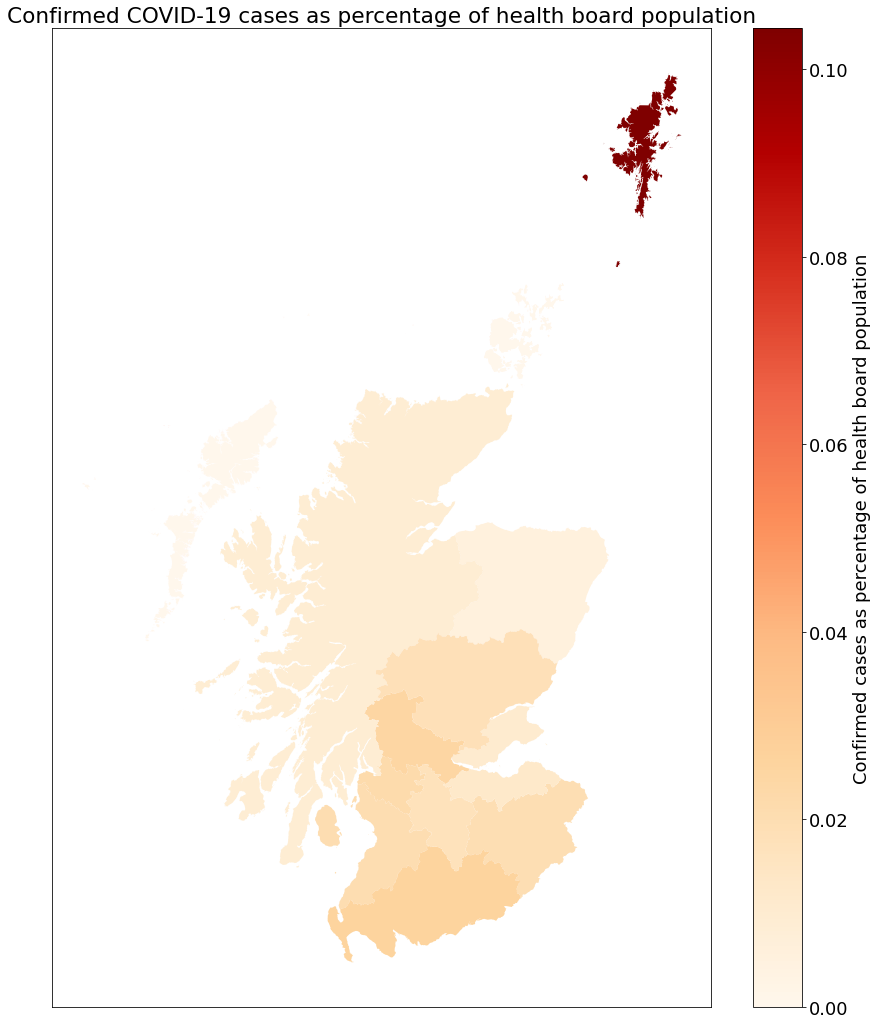

In [475]:
ax = percentage_confirmed_cases_of_health_board_population_geo_df.plot(column=percentage_confirmed_cases_of_health_board_population_geo_df.columns[0], figsize=figsize, legend=True, legend_kwds={'label': "Confirmed cases as percentage of health board population"}, cmap='OrRd')
ax.set_yticks([])
ax.set_xticks([])
plt.title('Confirmed COVID-19 cases as percentage of health board population')
plt.savefig('output/confirmed_cases_as_percentage_of_health_board_population.png')

In [476]:
mean_daily_percent_increase_by_board_geo_df = gpd.GeoDataFrame(mean_daily_percent_increase_by_board, geometry=simplified_health_boards.geometry)

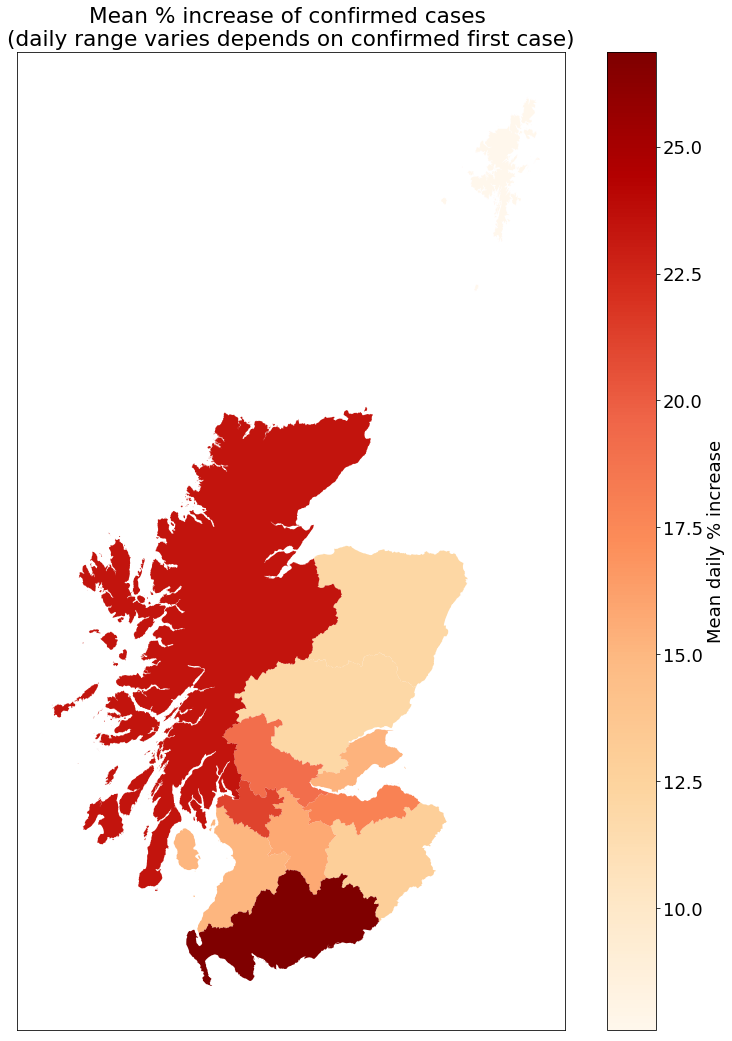

In [477]:
ax = mean_daily_percent_increase_by_board_geo_df.plot(column=mean_daily_percent_increase_by_board_geo_df.columns[0], figsize=(15,18), legend=True, legend_kwds={'label': "Mean daily % increase"}, cmap='OrRd')
ax.set_yticks([])
ax.set_xticks([])
plt.title("Mean % increase of confirmed cases \n(daily range varies depends on confirmed first case)")
plt.savefig('output/mean_percent_increase_by_health_board.png')

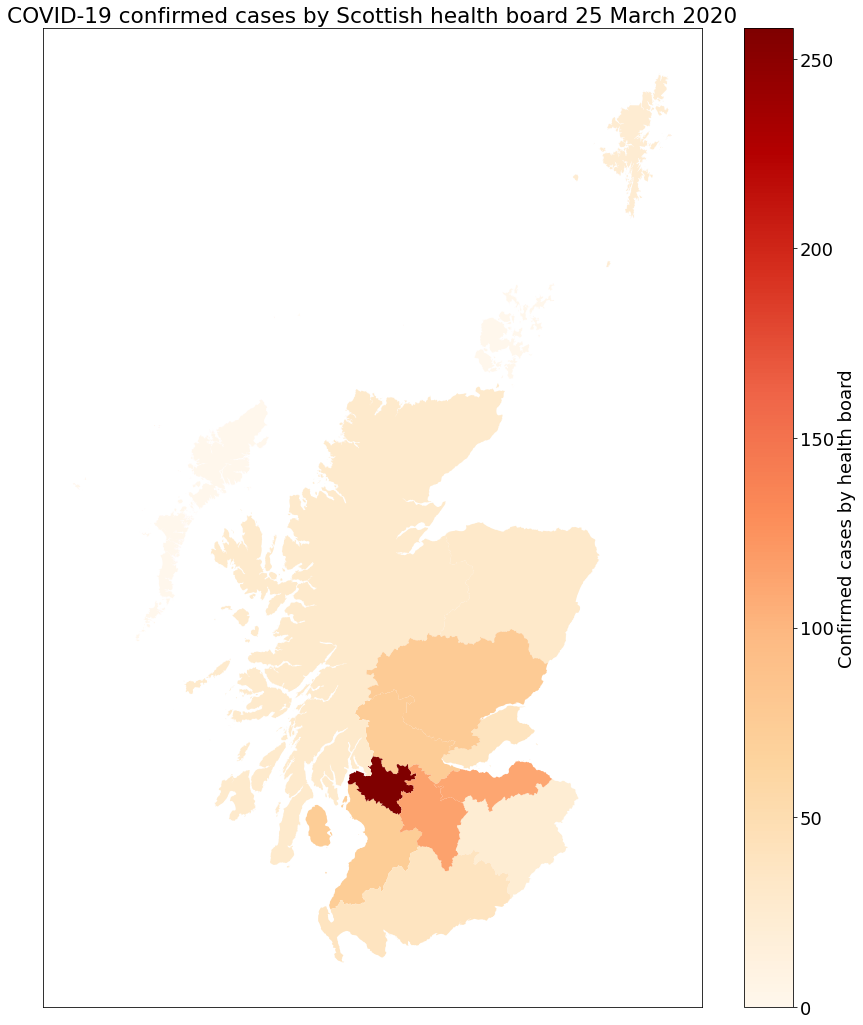

In [479]:
ax = health_board_geo_df.plot(column=health_board_geo_df.columns[0], figsize=(15,18), legend=True, legend_kwds={'label': "Confirmed cases by health board"}, cmap='OrRd')
plt.title('COVID-19 confirmed cases by Scottish health board 25 March 2020')
ax.set_yticks([])
ax.set_xticks([])
plt.savefig("output/confirmed_cases_" + str(date) + ".png")

In [228]:
health_board_geo_df.to_file('gis/scottish_health_board_counts_' + date + '.gpkg', driver='GPKG')

## Comparison with wikipedia data

In [ ]:
wiki_data = pd.read_csv('wikipedia_numbers.csv', index_col=0)

In [ ]:
initial_counts = all_results.counts.iloc[0]

In [ ]:
count_difference.sum() + initial_counts

In [ ]:
count_difference = all_results.counts.diff().fillna(0).astype('int')

In [ ]:
wiki_data

In [ ]:
differences = pd.DataFrame(count_difference.values - wiki_data[4:].values, index = count_difference.index, columns=count_difference.columns)

In [ ]:
differences